In [1]:
import pandas as pd
import scipy.spatial.distance as sci_dist
import matplotlib
# matplotlib.use('QtAgg')
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
import re
from scipy.stats import poisson, ks_2samp

tools_path = '../helperScripts/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

# Set matplotlib configs
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text
Image.MAX_IMAGE_PIXELS = None
np.random.seed(0)

# --- Paths ---
# invivo_data_folder = '/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
# invitro_data_folder = '/Users/YaelHeyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_2/exports'

invitro_data_folder = tools.roi_file_paths['dish_roi2']["out_path"]
invivo_data_folder = tools.roi_file_paths['roi_2']["out_path"]

sample_colors = ['#377eb8','#ff7f00','#e41a1c']


invivo_output_folder = os.path.join(invivo_data_folder, 'processedData')
invitro_output_folder = os.path.join(invitro_data_folder, 'processedData')

# --- Load barcode and gene means ---
invivo_bc_means = pd.read_csv(os.path.join(invivo_output_folder, "barcode_summary.csv"))
invitro_bc_means = pd.read_csv(os.path.join(invitro_output_folder, "barcode_summary.csv"))

invivo_gene_means = pd.read_csv(os.path.join(invivo_output_folder, "gene_summary.csv"))
invitro_gene_means = pd.read_csv(os.path.join(invitro_output_folder, "gene_summary.csv"))

# --- KS test: all barcodes ---
stat_bc, p_bc = ks_2samp(invivo_bc_means['mean'], invitro_bc_means['mean'])
print("Barcode KS statistic:", stat_bc)
print("Barcode p-value:", p_bc)

# --- Intersect top 15 genes in both datasets ---
top15_invitro = invitro_gene_means.sort_values(by='mean', ascending=False).head(10)['Unnamed: 0']
top15_invivo = invivo_gene_means.sort_values(by='mean', ascending=False).head(10)['Unnamed: 0']

shared_top_genes = sorted(set(top15_invitro).intersection(top15_invivo))

# --- Remove 'GFP' if present ---
shared_top_genes = [gene for gene in shared_top_genes if gene != 'GFP']
print(shared_top_genes)
# --- Filter and align both datasets ---
invitro_top = invitro_gene_means[invitro_gene_means['Unnamed: 0'].isin(shared_top_genes)].set_index('Unnamed: 0').loc[shared_top_genes]
invivo_top = invivo_gene_means[invivo_gene_means['Unnamed: 0'].isin(shared_top_genes)].set_index('Unnamed: 0').loc[shared_top_genes]

# --- KS test on shared top genes ---
stat_gene_top, p_gene_top = ks_2samp(invivo_top['mean'], invitro_top['mean'])
print("\nShared Top Genes (n={}): KS statistic:".format(len(shared_top_genes)), stat_gene_top)
print("Shared Top Genes p-value:", p_gene_top)

# --- Mean comparisons ---
mean_invivo_genes = invivo_top['mean'].mean()
mean_invitro_genes = invitro_top['mean'].mean()
print("Mean expression of shared top genes (in vivo):", mean_invivo_genes)
print("Mean expression of shared top genes (in vitro):", mean_invitro_genes)

mean_invivo_bc = invivo_bc_means['mean'].mean()
mean_invitro_bc = invitro_bc_means['mean'].mean()
print("Mean barcode expression (in vivo):", mean_invivo_bc)
print("Mean barcode expression (in vitro):", mean_invitro_bc)



# --- Get top 15 genes by area-normalized mean in each dataset ---
top15_invitro_norm = invitro_gene_means.sort_values(by='mean_per_area', ascending=False).head(15)['Unnamed: 0']
top15_invivo_norm = invivo_gene_means.sort_values(by='mean_per_area', ascending=False).head(15)['Unnamed: 0']

# --- Intersect and remove 'GFP' ---
shared_top_genes_norm = sorted(set(top15_invitro_norm).intersection(top15_invivo_norm))
shared_top_genes_norm = [g for g in shared_top_genes_norm if g != 'GFP']

# --- Filter and align both datasets by 'mean_per_area' ---
invitro_top_norm = invitro_gene_means[invitro_gene_means['Unnamed: 0'].isin(shared_top_genes_norm)].set_index('Unnamed: 0').loc[shared_top_genes_norm]
invivo_top_norm = invivo_gene_means[invivo_gene_means['Unnamed: 0'].isin(shared_top_genes_norm)].set_index('Unnamed: 0').loc[shared_top_genes_norm]

# --- KS test on area-normalized shared top genes ---
stat_norm, p_norm = ks_2samp(invivo_top_norm['mean_per_area'], invitro_top_norm['mean_per_area'])
print("\n[Area-normalized] Shared Top Genes (n={}): KS statistic:".format(len(shared_top_genes_norm)), stat_norm)
print("p-value:", p_norm)

# --- Mean comparison ---
mean_invivo_norm = invivo_top_norm['mean_per_area'].mean()
mean_invitro_norm = invitro_top_norm['mean_per_area'].mean()
print("Mean area-normalized expression (in vivo):", mean_invivo_norm)
print("Mean area-normalized expression (in vitro):", mean_invitro_norm)


# --- KS test: area-normalized barcode expression ---
stat_bc_norm, p_bc_norm = ks_2samp(invivo_bc_means['mean_per_area'], invitro_bc_means['mean_per_area'])
print("\n[Area-normalized] Barcode KS statistic:", stat_bc_norm)
print("Barcode p-value:", p_bc_norm)

# --- Mean comparison ---
mean_invivo_bc_norm = invivo_bc_means['mean_per_area'].mean()
mean_invitro_bc_norm = invitro_bc_means['mean_per_area'].mean()
print("Mean area-normalized barcode expression (in vivo):", mean_invivo_bc_norm)
print("Mean area-normalized barcode expression (in vitro):", mean_invitro_bc_norm)


Barcode KS statistic: 0.5104166666666666
Barcode p-value: 9.449738002943289e-12
['CAPG', 'CCND1', 'L1CAM', 'MMP1', 'SPARC']

Shared Top Genes (n=5): KS statistic: 0.8
Shared Top Genes p-value: 0.07936507936507936
Mean expression of shared top genes (in vivo): 15.117518559579901
Mean expression of shared top genes (in vitro): 28.350885596102835
Mean barcode expression (in vivo): 10.19273410605982
Mean barcode expression (in vitro): 14.95914747491382

[Area-normalized] Shared Top Genes (n=9): KS statistic: 0.2222222222222222
p-value: 0.9894693541752365
Mean area-normalized expression (in vivo): 0.0011934443888672
Mean area-normalized expression (in vitro): 0.0012234043387735556

[Area-normalized] Barcode KS statistic: 0.13541666666666666
Barcode p-value: 0.34359375969646605
Mean area-normalized barcode expression (in vivo): 0.0009384751548414385
Mean area-normalized barcode expression (in vitro): 0.0008509273625513239


In [2]:
np.mean(invivo_gene_means["mean"])

5.188219979328732

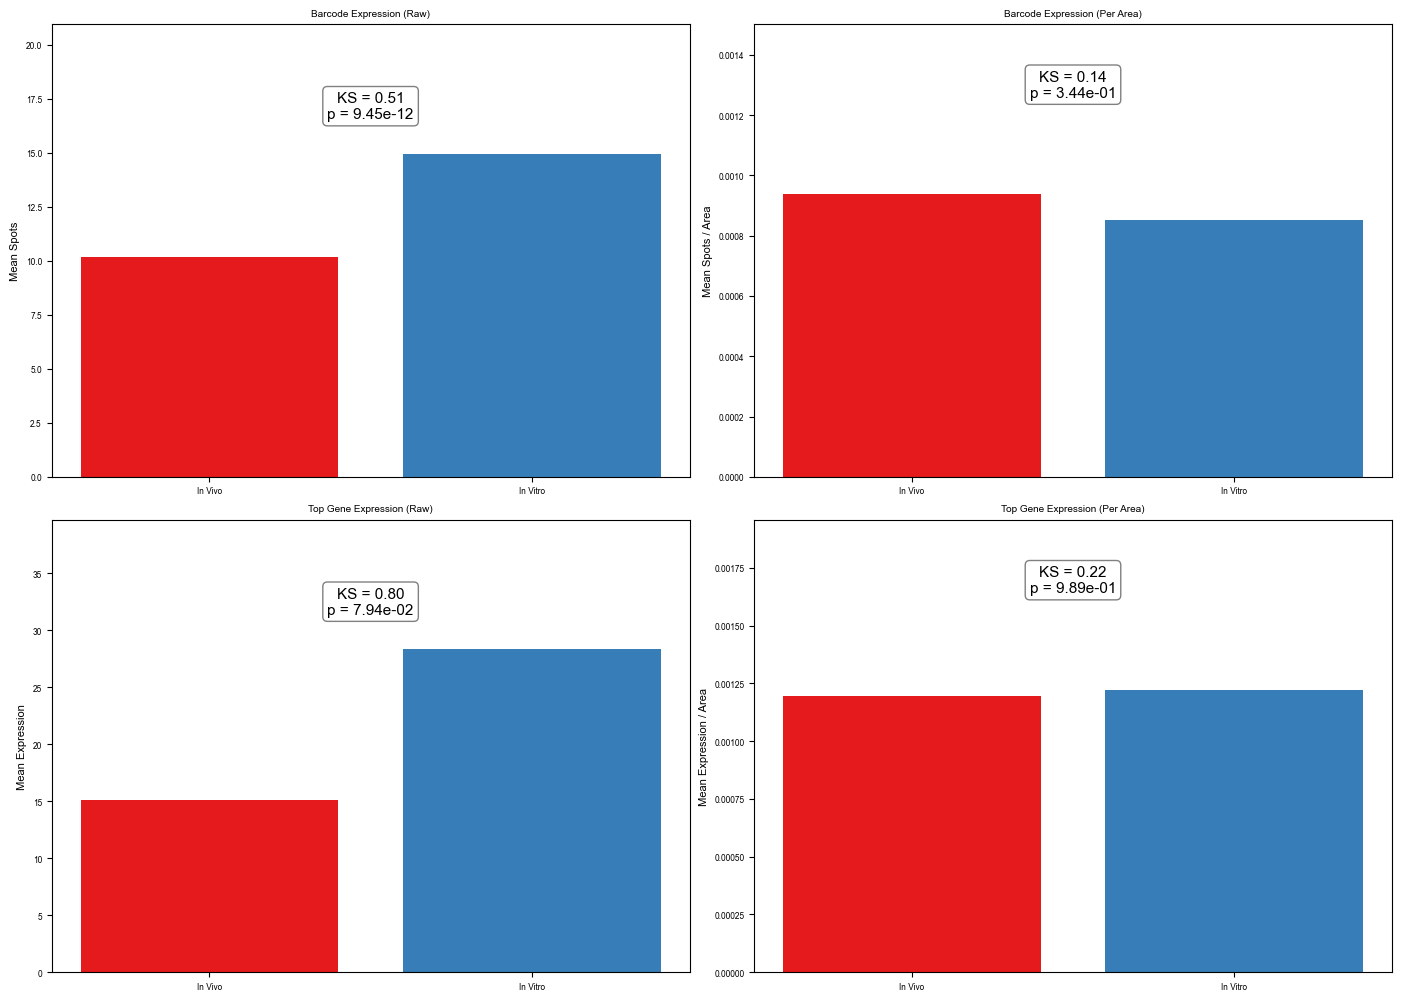

In [3]:
# --- Visualization with fixed textbox placement per panel side ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Data for plotting
plot_data = [
    {
        'title': 'Barcode Expression (Raw)',
        'values': [mean_invivo_bc, mean_invitro_bc],
        'ylabel': 'Mean Spots',
        'pval': p_bc,
        'stat': stat_bc
    },
    {
        'title': 'Barcode Expression (Per Area)',
        'values': [mean_invivo_bc_norm, mean_invitro_bc_norm],
        'ylabel': 'Mean Spots / Area',
        'pval': p_bc_norm,
        'stat': stat_bc_norm
    },
    {
        'title': 'Top Gene Expression (Raw)',
        'values': [mean_invivo_genes, mean_invitro_genes],
        'ylabel': 'Mean Expression',
        'pval': p_gene_top,
        'stat': stat_gene_top
    },
    {
        'title': 'Top Gene Expression (Per Area)',
        'values': [mean_invivo_norm, mean_invitro_norm],
        'ylabel': 'Mean Expression / Area',
        'pval': p_norm,
        'stat': stat_norm
    }
]

# Plot each panel
for i, ax in enumerate(axs):
    values = plot_data[i]['values']
    stat = plot_data[i]['stat']
    pval = plot_data[i]['pval']

    ax.bar(['In Vivo', 'In Vitro'], values, color=[sample_colors[2],sample_colors[0]])
    ax.set_title(plot_data[i]['title'])
    ax.set_ylabel(plot_data[i]['ylabel'])

    # Adjust y-limit to make room for the text box
    y_max = max(values) * (1.4 if i % 2 == 0 else 1.6)
    ax.set_ylim(0, y_max)

    # Format the text box
    textstr = f"KS = {stat:.2f}\np = {pval:.2e}"
    props = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')

    # Position: left panels (data units), right panels (axis units)
    if i % 2 == 0:  # left panels
        y_text = max(values) * 1.1
        ax.text(0.5, y_text, textstr,
                fontsize=11, verticalalignment='bottom', horizontalalignment='center',
                bbox=props, transform=ax.transData)
    else:  # right panels
        ax.text(0.5, 0.9, textstr,
                fontsize=11, verticalalignment='top', horizontalalignment='center',
                bbox=props, transform=ax.transAxes)

plt.tight_layout()
# plt.savefig('/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/invivo_invitro_comp.pdf')
# plt.savefig('/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/invivo_invitro_comp.png')
# plt.show()


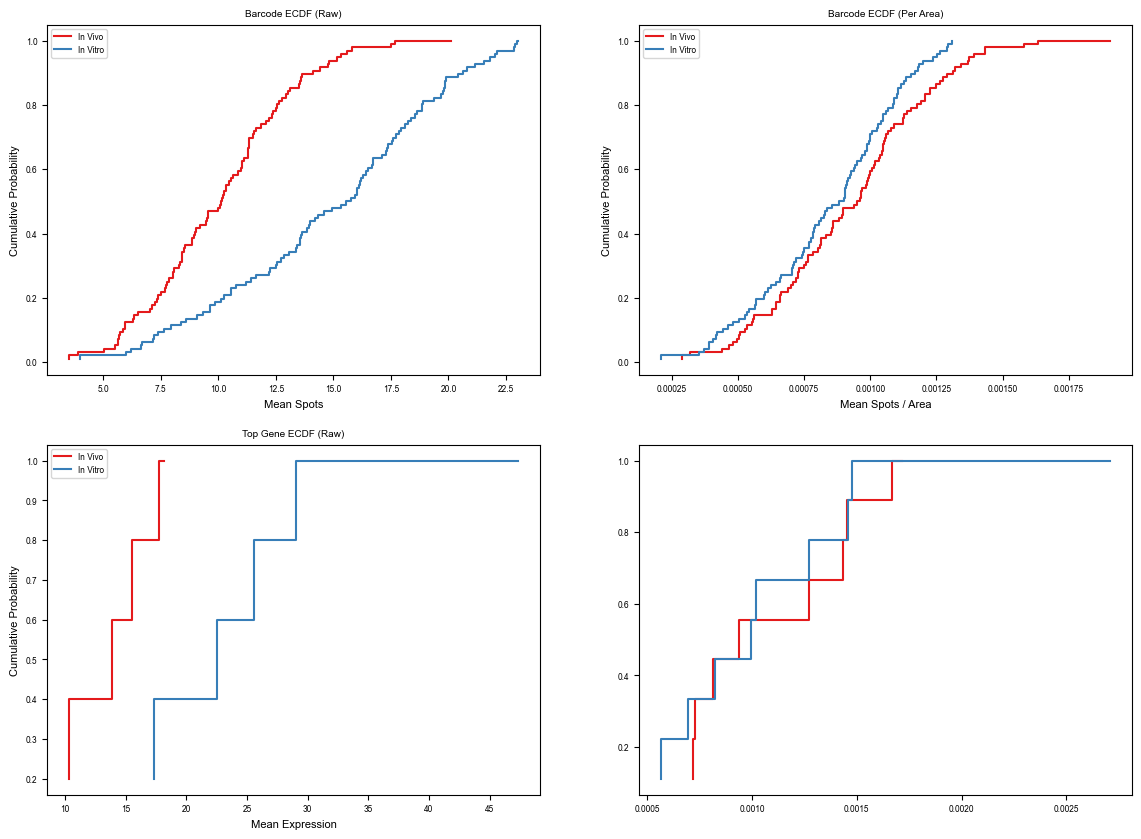

In [4]:
# --- Create ECDF plots comparing in vivo and in vitro distributions ---

from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

# Compute ECDFs
ecdf_bc_invivo = ECDF(invivo_bc_means['mean'])
ecdf_bc_invitro = ECDF(invitro_bc_means['mean'])

ecdf_gene_invivo = ECDF(invivo_top['mean'])
ecdf_gene_invitro = ECDF(invitro_top['mean'])

ecdf_bc_invivo_norm = ECDF(invivo_bc_means['mean_per_area'])
ecdf_bc_invitro_norm = ECDF(invitro_bc_means['mean_per_area'])

ecdf_gene_invivo_norm = ECDF(invivo_top_norm['mean_per_area'])
ecdf_gene_invitro_norm = ECDF(invitro_top_norm['mean_per_area'])

# Set up plot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Raw barcode ECDF
axs[0, 0].step(ecdf_bc_invivo.x, ecdf_bc_invivo.y, label='In Vivo', color=sample_colors[2])
axs[0, 0].step(ecdf_bc_invitro.x, ecdf_bc_invitro.y, label='In Vitro', color=sample_colors[0])
axs[0, 0].set_title('Barcode ECDF (Raw)')
axs[0, 0].set_xlabel('Mean Spots')
axs[0, 0].set_ylabel('Cumulative Probability')
axs[0, 0].legend()

# Area-normalized barcode ECDF
axs[0, 1].step(ecdf_bc_invivo_norm.x, ecdf_bc_invivo_norm.y, label='In Vivo', color=sample_colors[2])
axs[0, 1].step(ecdf_bc_invitro_norm.x, ecdf_bc_invitro_norm.y, label='In Vitro', color=sample_colors[0])
axs[0, 1].set_title('Barcode ECDF (Per Area)')
axs[0, 1].set_xlabel('Mean Spots / Area')
axs[0, 1].set_ylabel('Cumulative Probability')
axs[0, 1].legend()

# Raw gene ECDF
axs[1, 0].step(ecdf_gene_invivo.x, ecdf_gene_invivo.y, label='In Vivo', color=sample_colors[2])
axs[1, 0].step(ecdf_gene_invitro.x, ecdf_gene_invitro.y, label='In Vitro', color=sample_colors[0])
axs[1, 0].set_title('Top Gene ECDF (Raw)')
axs[1, 0].set_xlabel('Mean Expression')
axs[1, 0].set_ylabel('Cumulative Probability')
axs[1, 0].legend()

# Area-normalized gene ECDF
axs[1, 1].step(ecdf_gene_invivo_norm.x, ecdf_gene_invivo_norm.y, label='In Vivo', color=sample_colors[2])
axs[1, 1].step(ecdf_gene_invitro_norm.x, ecdf_gene_invitro_norm.y, label='In Vitro', color=sample_colors[0])
plt.show()


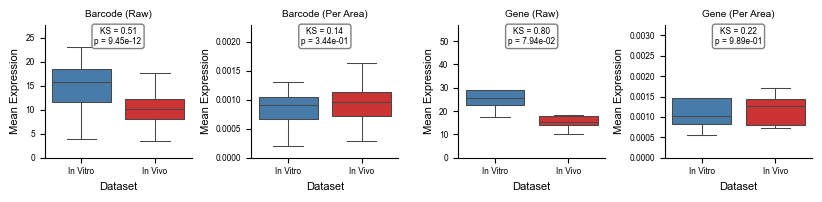

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# --- Define all KS tests ---
stat_bc, p_bc = ks_2samp(invivo_bc_means['mean'], invitro_bc_means['mean'])
stat_bc_norm, p_bc_norm = ks_2samp(invivo_bc_means['mean_per_area'], invitro_bc_means['mean_per_area'])
stat_gene_top, p_gene_top = ks_2samp(invivo_top['mean'], invitro_top['mean'])
stat_norm, p_norm = ks_2samp(invivo_top_norm['mean_per_area'], invitro_top_norm['mean_per_area'])

# --- Build plot info list ---
box_data = [
    {
        'title': 'Barcode (Raw)',
        'in_vivo': invivo_bc_means['mean'],
        'in_vitro': invitro_bc_means['mean'],
        'stat': stat_bc,
        'pval': p_bc
    },
    {
        'title': 'Barcode (Per Area)',
        'in_vivo': invivo_bc_means['mean_per_area'],
        'in_vitro': invitro_bc_means['mean_per_area'],
        'stat': stat_bc_norm,
        'pval': p_bc_norm
    },
    {
        'title': 'Gene (Raw)',
        'in_vivo': invivo_top['mean'],
        'in_vitro': invitro_top['mean'],
        'stat': stat_gene_top,
        'pval': p_gene_top
    },
    {
        'title': 'Gene (Per Area)',
        'in_vivo': invivo_top_norm['mean_per_area'],
        'in_vitro': invitro_top_norm['mean_per_area'],
        'stat': stat_norm,
        'pval': p_norm
    }
]

# --- Create plots ---
fig, axs = plt.subplots(1, 4, figsize=(8.2, 2))
plt.subplots_adjust(wspace=0.05)
axs = axs.flatten()
sns.despine()

for i, entry in enumerate(box_data):
    # Combine into single DataFrame
    df_plot = pd.DataFrame({
        'value': pd.concat([entry['in_vitro'],entry['in_vivo']], ignore_index=True),
        'Dataset': ['In Vitro'] * len(entry['in_vitro']) + ['In Vivo'] * len(entry['in_vivo'])
    })

    sns.boxplot(data=df_plot, x='Dataset', y='value', ax=axs[i],
                palette=[sample_colors[0], sample_colors[2]], showfliers=False,linewidth=0.75,)

    axs[i].set_title(entry['title'])
    axs[i].set_ylabel('Mean Expression')

    # Text box annotation
    y_max = df_plot['value'].max()
    axs[i].set_ylim(0, y_max * 1.2)
    y_text = y_max * 1.05
    textstr = f"KS = {entry['stat']:.2f}\np = {entry['pval']:.2e}"
    props = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
    axs[i].text(0.5, 0.99, textstr, transform=axs[i].transAxes,
                fontsize=6, verticalalignment='top', horizontalalignment='center', bbox=props)

plt.tight_layout()
plt.savefig('../graphs/invivo_vs_invitro_expression_box.pdf',bbox_inches='tight',transparent=True)
# plt.savefig('/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/invivo_invitro_comp_box.png')
# plt.show()


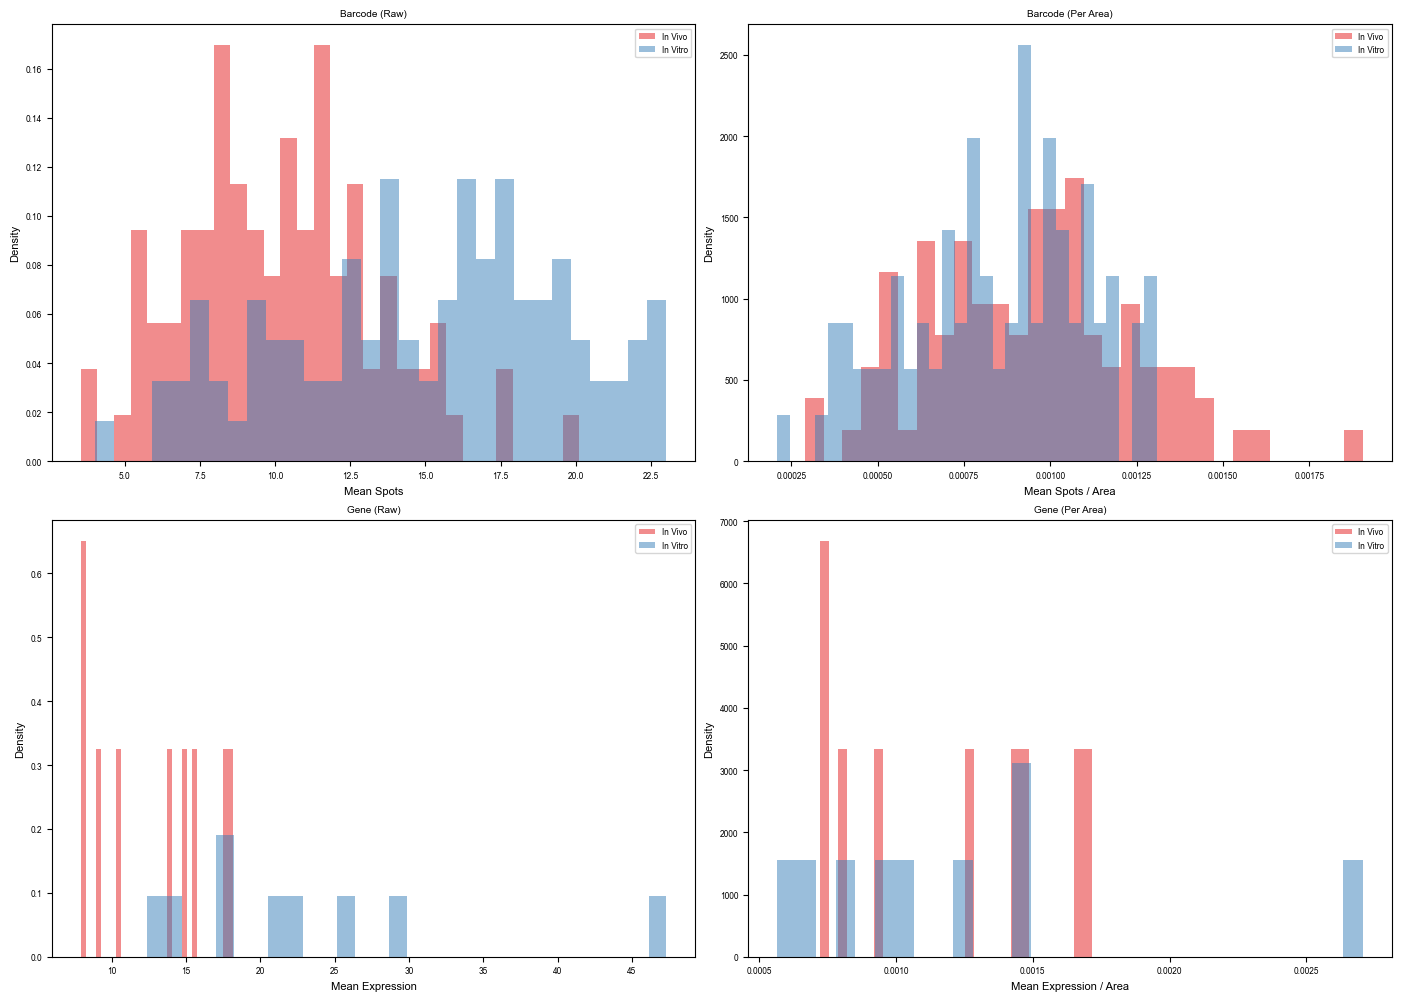

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# --- Recompute shared top genes and extract matching rows ---
top15_invitro = invitro_gene_means.sort_values(by='mean', ascending=False).head(15)['Unnamed: 0']
top15_invivo = invivo_gene_means.sort_values(by='mean', ascending=False).head(15)['Unnamed: 0']
shared_top_genes = sorted(set(top15_invitro).intersection(top15_invivo))
shared_top_genes = [g for g in shared_top_genes if g != 'GFP']

invitro_top = invitro_gene_means.set_index('Unnamed: 0').loc[shared_top_genes]
invivo_top = invivo_gene_means.set_index('Unnamed: 0').loc[shared_top_genes]

top15_invitro_norm = invitro_gene_means.sort_values(by='mean_per_area', ascending=False).head(15)['Unnamed: 0']
top15_invivo_norm = invivo_gene_means.sort_values(by='mean_per_area', ascending=False).head(15)['Unnamed: 0']
shared_top_genes_norm = sorted(set(top15_invitro_norm).intersection(top15_invivo_norm))
shared_top_genes_norm = [g for g in shared_top_genes_norm if g != 'GFP']

invitro_top_norm = invitro_gene_means.set_index('Unnamed: 0').loc[shared_top_genes_norm]
invivo_top_norm = invivo_gene_means.set_index('Unnamed: 0').loc[shared_top_genes_norm]

# --- KS statistics ---
stat_bc, p_bc = ks_2samp(invivo_bc_means['mean'], invitro_bc_means['mean'])
stat_bc_norm, p_bc_norm = ks_2samp(invivo_bc_means['mean_per_area'], invitro_bc_means['mean_per_area'])
stat_gene_top, p_gene_top = ks_2samp(invivo_top['mean'], invitro_top['mean'])
stat_norm, p_norm = ks_2samp(invivo_top_norm['mean_per_area'], invitro_top_norm['mean_per_area'])

# --- Prepare histogram plot ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

hist_data = [
    {
        'title': 'Barcode (Raw)',
        'in_vivo': invivo_bc_means['mean'],
        'in_vitro': invitro_bc_means['mean'],
        'stat': stat_bc,
        'pval': p_bc,
        'xlabel': 'Mean Spots'
    },
    {
        'title': 'Barcode (Per Area)',
        'in_vivo': invivo_bc_means['mean_per_area'],
        'in_vitro': invitro_bc_means['mean_per_area'],
        'stat': stat_bc_norm,
        'pval': p_bc_norm,
        'xlabel': 'Mean Spots / Area'
    },
    {
        'title': 'Gene (Raw)',
        'in_vivo': invivo_top['mean'],
        'in_vitro': invitro_top['mean'],
        'stat': stat_gene_top,
        'pval': p_gene_top,
        'xlabel': 'Mean Expression'
    },
    {
        'title': 'Gene (Per Area)',
        'in_vivo': invivo_top_norm['mean_per_area'],
        'in_vitro': invitro_top_norm['mean_per_area'],
        'stat': stat_norm,
        'pval': p_norm,
        'xlabel': 'Mean Expression / Area'
    }
]

# --- Plot loop ---
for i, entry in enumerate(hist_data):
    ax = axs[i]
    ax.hist(entry['in_vivo'], bins=30, alpha=0.5, color=sample_colors[2], label='In Vivo', density=True)
    ax.hist(entry['in_vitro'], bins=30, alpha=0.5, color=sample_colors[0], label='In Vitro', density=True)

    ax.set_title(entry['title'])
    ax.set_xlabel(entry['xlabel'])
    ax.set_ylabel('Density')
    ax.legend()

    y_max = ax.get_ylim()[1]
    textstr = f"KS = {entry['stat']:.2f}\np = {entry['pval']:.2e}"
    props = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')

    # ax.text(0.5, y_max * 0.95, textstr,
    #         transform=ax.transAxes,
    #         fontsize=11, verticalalignment='top', horizontalalignment='center', bbox=props)

plt.tight_layout()
# plt.savefig('/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/invivo_invitro_comp_hist.pdf')
# plt.savefig('/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/invivo_invitro_comp_hist.png')
plt.show()
